# MNIST and CNN architecture

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
# setting the device
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# calling the dataset
from tensorflow.keras.datasets import mnist

# access the training and test data
(Xtr_raw, Ytr_raw), (Xte_raw, Yte_raw)= mnist.load_data()

(Xtr_raw.shape, Ytr_raw.shape), (Xte_raw.shape, Yte_raw.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

The reshape function changes the dimensions of the data to prepare it for input into the neural network. It reshapes the images into 4D dimensions with the size of (number of samples, image height, image width, number of channels). In MNIST, the dimensions of the images are (60000, 28, 28), which are reshaped to (60000, 1, 28, 28). This is necessary to match the input size of the neural network layers.

In [ ]:
# data reformating - adding a channel dimension
Xtr_raw= np.expand_dims(Xtr_raw, 1) # Grayscale images have 1 channel
Xte_raw= np.expand_dims(Xte_raw, 1)

# (instances, channels, x, y)
Xtr_raw.shape

(60000, 1, 28, 28)

# Data processing

Some datasets, like MNIST, require minimal processing, but real-world data is not always so straightforward.

If normalization is not performed, one of the issues that arises is convergence problems, which may result in the model converging slowly or not converging at all. There are various methods of normalization. These include Pixel-wise normalization (where each pixel of the image is normalized based on the mean and variance of similar pixels in the dataset), Local Contrast normalization (useful for images with local brightness variations, where each region of the image is normalized relative to similar regions in all data), Robust Scaling (which uses the median and interquartile range of the data for scaling, making it robust against outliers), and Unit Vector Scaling (where each row of the data is normalized in such a way that the sum of squares of its values equals one).

The Min-Max Scaling method is more suitable for data with a normal distribution or similar. When the data have a non-normal distribution, such as MNIST, the Z-score method is usually more useful because it normalizes the data based on the mean and variance.

In [ ]:
# For the MNIST dataset, normalization may be useful but often not necessary.
# We will just subtract the mean image for centering (e.g., AlexNet)
# see https://www.youtube.com/watch?v=gYpoJMlgyXA

# convert data to float32
Xtr_raw= Xtr_raw.astype(np.float32)
Xte_raw= Xte_raw.astype(np.float32)

# calculate the mean of the training data
Xmean= np.mean(Xtr_raw)

# apply the centering to the training data
Xtr_raw -= Xmean

# apply the centering to the test data using the mean of the training data
Xte_raw -= Xmean

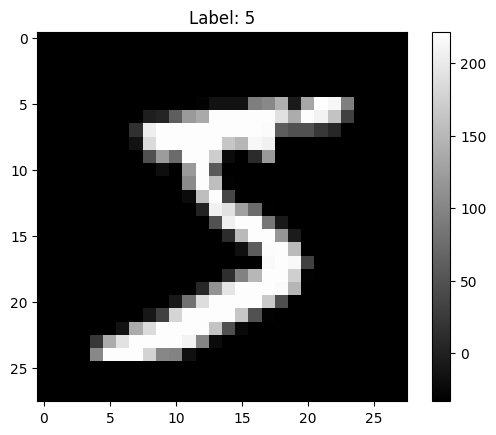

In [ ]:
# rendering one example
plt.imshow(Xtr_raw[0][0], cmap='gray')
plt.colorbar()
plt.title(f'Label: {Ytr_raw[0]}')
plt.show()

In [ ]:
# converting data to pytorch type
Xtr= torch.tensor(Xtr_raw, requires_grad=True).to(device)
Ytr= torch.tensor(Ytr_raw).to(device)
Xte= torch.tensor(Xte_raw, requires_grad=True).to(device)
Yte= torch.tensor(Yte_raw).to(device)

# transforming labels from numbers to one-hot vectors of length 10
Ytr= F.one_hot(Ytr.type(torch.int64), num_classes=10).type(torch.float32)
Yte= F.one_hot(Yte.type(torch.int64), num_classes=10).type(torch.float32)

# creating a dev dataset from training data
tr_size= int(0.8*Xtr.shape[0])

Xdev= Xtr[tr_size:]
Ydev= Ytr[tr_size:]

Xtr= Xtr[:tr_size]
Ytr= Ytr[:tr_size]

print(f'Shape of training: Xtr - {Xtr.shape}, Ytr - {Ytr.shape}')
print(f'Shape of dev data: Xdev - {Xdev.shape}, Ydev - {Ydev.shape}')
print(f'Shape of test data: Xte - {Xte.shape}, Yte - {Yte.shape}')

Shape of training: Xtr - torch.Size([48000, 1, 28, 28]), Ytr - torch.Size([48000, 10])
Shape of dev data: Xdev - torch.Size([12000, 1, 28, 28]), Ydev - torch.Size([12000, 10])
Shape of test data: Xte - torch.Size([10000, 1, 28, 28]), Yte - torch.Size([10000, 10])


# Architecture Design (Model Building)

Using PyTorch to create a customizable version of AlexNet. This model has two general parts: the convolutional backbone and the densely connected head.

CNNs operate over volumes; all of the layers in between are going to take volumes of activations and are going to produce volumes of activations, so the intermediates are not as vectors lake NNs, but they have spatial dimensions (width, height, and depth -- or channels) that will maintain the computations.

https://www.youtube.com/watch?v=LxfUGhug-iQ

**NOTE:** ReLU is historically used in AlexNet and performs well. However, alternatives like GELU or Swish may improve performance, especially in deeper or more modern networks.

In [ ]:
class Activation(nn.Module):
    """
    Activation functions. ReLU is the default in AlexNet.
    The inplace=True helps to save memory by modifying the input directly.
    """

    def __init__(self, activation='relu') -> None:
        super(Activation, self).__init__()
        if 'relu' in activation:
            self.activ= nn.ReLU(inplace=True)
        elif 'gelu' in activation:
            self.activ= nn.GELU()
        elif 'swish' in activation:
            self.activ= nn.SiLU()
        else:
            self.activ= nn.Tanh()


    def forward(self, x):

        return self.activ(x)


For deep convolutional networks, it is necessary to define padding values; otherwise, the convolutional operation will always decrease the input size (spatial downsampling), and this is not we might want necessarily because if we collapse the size of our representation too quickly, then the total amount of convolutional layers (depth) is limited. For 3x3 kernels, paddings of 1 keep the input space (with stride=1). The spatial downsampling procedure is managed by applying pooling layers (preserving the volume of the convolution).

AlexNet (8 layers, 60M parameters) - Input image: 227x227x3
- 1st layer (conv) 96 11x11 filters, stride 4. Output volume: 55x55x96. Parameters (11x11x3)x96 = 35K
- 2nd layer - normalization
- 3rd layer (pool) 3x3 filters, stride 2. Output volume: 27x27x96 ((55-3)/2+1 = 27). Pool layers have zero parameters.
- 4st layer (conv) ...
- Output volume at the end of the Backbone module: 6x6x256
- Head - two FC layers with 4096 neurons each
- Output (class scores) 1000 neurons

AlexNet details: ReLU, dropout 0.5, batch size 128, SGD Momentum 0.9, learning rate 1e-2 manually reduced by 10, L2 weight decay 5e-4.

VGGNet (19 layers): only 3x3 conv with stride 1 and pad 1, and Max Pool stride 2. Spacially decreases the input but the volumes of convs get more depth (output volume of backbone is 7x7x512).

ResNet: Xavier/2 init, batch norm after every conv layer, no dropout, batch size 256, SGD Momentum 0.9, learning rate 0.1 reduced by 10 when validation error plateaus, weight decay 1e-5. Very deep architecture (152 layers) introduces residual (skip) connections (the input flows in, but instead of computing how to transform the input, ResNet computes what to add to the input). In the backward pass, skip connections allow the gradient to skip right through the layers, preventing it vanishes.

https://www.youtube.com/watch?v=LxfUGhug-iQ

In [ ]:
class Initializer:
    """
    Validades hyperparameters for the CNN model and initializes the weights.
    """

    def __init__(self, activation='relu') -> None:
        self.activation= activation
        self.n_hidden= 0


    def check_dims(self, dim, is_hidden=False):
        if not is_hidden:
            assert isinstance(dim, int), 'Input/output dimension must be an integer'
            assert dim> 0, 'Input/output dimension cannot be zero'
        else:
            if isinstance(dim, int):
                assert dim> 0, 'hidden dimension cannot be zero'
                dim= [dim]
            assert all(isinstance(x, int) for x in dim), 'hidden must be a list of integers'
            n_hidden_layers= len(dim)

            self.n_hidden= n_hidden_layers

        return dim


    def check_hparams(self, hparam, name):
        assert self.n_hidden> 0, 'hidden_chs cannot be an empty list'

        if isinstance(hparam, (int, float)):
            hparam= [hparam] * (self.n_hidden + 1)
        if len(hparam)< (self.n_hidden + 1):
            raise ValueError(f"{name} must be defined for all {self.n_hidden+1} layers")
        if name!= 'dropout':
            assert all(isinstance(x, int) for x in hparam), f'{name} must be a list of integers'

        return hparam


    def weights(self, modules, method='random') -> None:
        for m in modules:
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            else:
                # nn.Conv2d and nn.Linear modules
                if hasattr(m, 'weight') and isinstance(m.weight, torch.Tensor):
                    if method== 'random':
                        nn.init.normal_(m.weight)
                    elif method== 'uniform':
                        nn.init.uniform_(m.weight)
                    elif method== 'xavier':
                        nn.init.xavier_normal_(m.weight)
                    elif method== 'xavier_uniform':
                        nn.init.xavier_uniform_(m.weight)
                    elif method== 'he':
                        nn.init.kaiming_normal_(m.weight, nonlinearity=self.activation)
                    elif method== 'he_uniform':
                        nn.init.kaiming_uniform_(m.weight, nonlinearity=self.activation)
                    else:
                        raise ValueError(f'Unknown initialization method: {method}')

                if hasattr(m, 'bias') and isinstance(m.bias, torch.Tensor):
                    nn.init.zeros_(m.bias)


**Xavier initialization** draws the weights of one layer in the network from uniform distribution. However, Xavier initialization is designed for tanh or sigmoid activation, and may lead to a reduction of gradients during back propagation due to the vanishing gradient problem caused by tanh or sigmoid. Therefore, Xavier initialization may not be suitable for a deep neural network using ReLU activation.

**He's initialization**, specifically designed for deep neural network with the ReLU activation that helps to reduce the vanishing gradient problem, allows the network to learn deeper representations. He's initialization draws the weights of one layer in the network from Gaussian distribution.

https://medium.com/@freshtechyy/weight-initialization-for-deep-neural-network-e0302b6f5bf3

# CNN Backbone

In [ ]:
class ConvLayer(nn.Module):
    """
    Implements one customizable CNN layer.
    AlexNet-style: Input -> Conv2d -> ReLU -> MaxPool2d -> Output
    """

    def __init__(self, in_chs, out_chs, kernel, stride, padding,
                 max_pool, pool_stride, norm, activation, dropout=0.0) -> None:
        super(ConvLayer, self).__init__()
        self.conv= nn.Conv2d(in_chs, out_chs, kernel, stride, padding)
        # Batch Normalization  -- not introduced when AlexNet came out
        self.norm= nn.BatchNorm2d(out_chs) if norm else None
        # Activation function -- ReLU is the default in AlexNet
        self.activ= Activation(activation)
        # Max pooling layer -- halves the feature maps each time
        self.max_pool= nn.MaxPool2d(max_pool, pool_stride) if max_pool> 0.0 else None
        # Dropout layer for regularization -- typically applied after max pooling
        self.dropout= nn.Dropout2d(p=dropout) if dropout> 0.0 else None


    def forward(self, x):
        x= self.conv(x)
        if self.norm is not None:
            x= self.norm(x)
        x= self.activ(x)
        if self.max_pool is not None:
            x= self.max_pool(x)
        if self.dropout is not None:
            x= self.dropout(x)

        return x



class Backbone(nn.Module):
    """
    Defines the CNN backbone.
    Modular setup, so you can easily experiment with different configurations.
    """

    def __init__(self, input_chs, output_chs, hidden_chs=[16,], kernels=3, conv_strides=1, paddings=0,
                 max_pool=2, pool_strides=2,
                 norm=1, activation='relu', dropout=0.0, initializer='he') -> None:
        super(Backbone, self).__init__()
        # Hyperparameter Validation
        init= Initializer(activation)

        input_chs = init.check_dims(input_chs)
        hidden_chs= init.check_dims(hidden_chs, is_hidden=True)
        output_chs= init.check_dims(output_chs)

        kernels= init.check_hparams(kernels, 'kernels')
        conv_strides= init.check_hparams(conv_strides, 'conv_strides')
        paddings= init.check_hparams(paddings, 'paddings')
        max_pool= init.check_hparams(max_pool, 'max_pool')
        pool_strides= init.check_hparams(pool_strides, 'pool_strides')
        norm= init.check_hparams(norm, 'norm')
        dropout= (init.check_hparams(dropout, 'dropout'))[:init.n_hidden]

        # Defines the CNN backbone architecture
        self.conv_in= ConvLayer(input_chs, hidden_chs[0], kernels[0], conv_strides[0], paddings[0],
                                max_pool[0], pool_strides[0], norm[0], activation, dropout[0])

        if init.n_hidden> 1:
            self.conv_hiddens= nn.Sequential(*[
                ConvLayer(ch, hidden_chs[i+1], k, cs, p, m, ps, n, activation, d)
                for i, (ch, k, cs, p, m, ps, n, d) in enumerate(zip(
                    hidden_chs[:-1], kernels[1:-1], conv_strides[1:-1], paddings[1:-1],
                    max_pool[1:-1], pool_strides[1:-1], norm[1:-1], dropout[1:]
                ))
            ])
        else: self.conv_hiddens= None
        # No dropout in the last ConvLayer
        self.conv_out= ConvLayer(hidden_chs[-1], output_chs, kernels[-1], conv_strides[-1], paddings[-1],
                                 max_pool[-1], pool_strides[-1], norm[-1], activation)

        init.weights(self.modules(), initializer)


    def forward(self, x):
        x= self.conv_in(x)
        if self.conv_hiddens is not None:
            x= self.conv_hiddens(x)
        x= self.conv_out(x)

        return x


# MLP Classification Head

In [ ]:
class MLPLayer(nn.Module):
    """
    Implements one customizable MLP layer.
    AlexNet-style: Dropout is placed before the FC layer.
    """

    def __init__(self, in_dim, out_dim, activation=None, dropout=0.0) -> None:
        super(MLPLayer, self).__init__()
        # Dropout layer for regularization
        self.dropout= nn.Dropout(p=dropout) if dropout> 0.0 else None
        # Fully connected (FC) layer
        self.fc= nn.Linear(in_dim, out_dim)
        # Activation function -- ReLU is the default in AlexNet
        # For the final layer: activation=None
        self.activ= Activation(activation) if activation is not None else None


    def forward(self, x):
        if self.dropout is not None:
            x= self.dropout(x)
        x= self.fc(x)
        if self.activ is not None:
            x= self.activ(x)

        return x



class Head(nn.Module):
    """
    Defines the MLP Projection Head (for data classification).
    """

    def __init__(self, input_dim, n_classes=1, hidden_dim=[16,],
                 activation='relu', dropout=0.0, initializer='he') -> None:
        super(Head, self).__init__()
        # Hyperparameter Validation
        init= Initializer(activation)

        input_dim = init.check_dims(input_dim)
        hidden_dim= init.check_dims(hidden_dim, is_hidden=True)
        n_classes = init.check_dims(n_classes)

        dropout= (init.check_hparams(dropout, 'dropout'))[-(init.n_hidden+1):]

        # Defines the classification head architecture
        self.fc_in= MLPLayer(input_dim, hidden_dim[0], activation, dropout[0])

        if init.n_hidden> 1:
            self.fc_hiddens= nn.Sequential(*[
                MLPLayer(hd, hidden_dim[i+1], activation, d)
                for i, (hd, d) in enumerate(zip(hidden_dim[:-1], dropout[1:-1]))
            ])
        else: self.fc_hiddens= None
        # No activation nor dropout in the last MLPLayer
        self.fc_out= MLPLayer(hidden_dim[-1], n_classes, dropout=0.0)

        init.weights(self.parameters(), initializer)


    def forward(self, x):
        x= self.fc_in(x)
        if self.fc_hiddens is not None:
            x= self.fc_hiddens(x)

        return self.fc_out(x)   # output layer -- logits


# Building the final CNN model

In [ ]:
class CNN_Model(nn.Module):
    """
    Defines the AlexNet-based CNN model - Feature extractor Conv backbone + classification FC head.
    """

    def __init__(self, input_chs, output_chs, hidden_chs=[16,], kernels=3, conv_strides=1, paddings=0,
                 max_pool=2, pool_strides=2, norm=1,                  # Conv
                 input_dim=1, n_classes=1, hidden_dim=[16,],          # MLP
                 activation='relu', dropout=0.0, initializer='he') -> None:
        super(CNN_Model, self).__init__()
        # Processes the input through the convolutional layers for initial feature extraction
        self.backbone= Backbone(
            input_chs, output_chs, hidden_chs, kernels, conv_strides, paddings,
            max_pool, pool_strides, norm, activation, dropout, initializer
        )

        # Average Pooling Layer (spatial global pooling)
        pool_size= int(math.sqrt(input_dim/output_chs))
        self.avg_pool= nn.AdaptiveAvgPool2d((pool_size, pool_size))
        # Flatten backbone output to transform the 2D feature maps into 1D feature vectors
        self.flatten= nn.Flatten(start_dim=1)

        # Runs the feature vector through the classifier to generate predictions for each class
        self.head= Head(
            input_dim, n_classes, hidden_dim, activation, dropout, initializer
        )


    def forward(self, x):                 # (batch_size, input_chs, x_height, x_width)
        x= self.backbone(x)               # (batch_size, output_chs, map_d1, map_d2)
        x= self.flatten(self.avg_pool(x)) # (batch_size, input_dim)
        x= self.head(x)                   # (batch_size, n_classes)

        return F.log_softmax(x, dim=1) # softmax activation on logits for classification


BatchNorm normalizes each feature within a batch of samples, while LayerNorm normalizes all features within each sample. Let's assume we have a two-dimensional input matrix, where the rows represent the batch and the columns represent the sample features. The target of Batch Normalization is a batch of samples (horizontal), and the target of Layer Normalization is a single sample (vertical).

For the field of computer vision, features depend on the statistical parameters between different samples, and **BatchNorm** is more effective. This is because it eliminates the size relationship between different features while preserving the size relationship between different samples.

In the field of NLP, **LayerNorm** is more appropriate. This is because the different features of a single sample are actually the variations in words over time, and the feature relationships within the sample are very close.

Typical architectures look like: [(Conv-ReLU)xN-Pool?]xM-(FC-ReLU)xK,Softmax
- where N is usually up to ~5, M is large, 0<= K <=2.
- but advances such as ResNet/GoogLeNet challenge this paradigm.

https://www.youtube.com/watch?v=LxfUGhug-iQ

In [ ]:
# ----- Backbone defs -----
input_chs=Xtr.shape[1] # the data is single-channel (grayscale)
hidden_chs=[32,64,]    # number of filters used in each convolutional layer
output_chs= 64         # number of channels in the output
kernels=3              # dimensions of the kernel or filter, which collects information from the images
conv_stride=1          # controls the stride for the cross-correlation, default is 1
paddings=1             # controls the amount of padding applied to each conv layer
max_pool=2             # performs pooling operations on the images
pool_stride=max_pool   # the stride of the pool window. Default value is pool_size
norm=1                 # BatchNorm in CNN layers
# ----- Head defs -----
input_dim=576
hidden_dim=[64,32,]    # dense (fully connected) layers
n_classes=10           # digits from 0 to 9
# ----- general defs -----
activation='relu'
dropout=0.1


model1= CNN_Model(input_chs, output_chs, hidden_chs, kernels, conv_stride, paddings,
                  max_pool, pool_stride, norm,
                  input_dim, n_classes, hidden_dim, activation, dropout).to(device)

total_params= sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

model1

Number of parameters: 95402


CNN_Model(
  (backbone): Backbone(
    (conv_in): ConvLayer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): Activation(
        (activ): ReLU(inplace=True)
      )
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
    (conv_hiddens): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Activation(
          (activ): ReLU(inplace=True)
        )
        (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
    (conv_out): ConvLayer(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), st

# Training Phase

After constructing the model and its layers with the CNN architecture, the next step is to set the loss function, optimizer, and select evaluation metrics. In machine learning, the loss function represents the difference between the model's output and the actual values. In all tasks, whether in the real world or for solving deep learning problems, one of the most important tasks is to minimize the error.

The optimizer is responsible for optimizing and updating the model's weights (W), adjusting them in a way that minimizes the loss function. Optimizers come in various types such as Adam, SGD, and RMSprop, and selecting the right one for your specific task can help improve the model's performance.

The learning rate determines how small the training steps should be to reach the optimal point. Selecting an appropriate learning rate is crucial in training a model.

Typically, when fitting the model, the first thing we do is specify the number of epochs. In each epoch, the model sees the entire training dataset once to learn complex patterns in the data. Naturally, the higher the number of epochs, the better the model learns because it can see more data, but if it's too high, it may lead to overfitting. In other words, because the model overly converges to the training data, it fails to generalize to new data. In other words, the model simply memorizes the data.

Determining the batch size specifies how many data samples are shown to the model in each epoch. Finding the optimal batch size has a significant impact on the speed and quality of model training. Naturally, a larger batch size is preferable for better performance. However, due to memory constraints, especially in large-scale projects, this may not always be feasible. In diverse datasets, a larger batch size may lead to a loss of model adaptation to the data, resulting in overfitting or underfitting. To prevent this, we can find the best batch size through trial and error or by employing systematic and principled methods such as Grid Search or Validation Data-based approaches.

# Supervised Learning

In [ ]:
# https://blog.stackademic.com/pytorch-a-beginners-tutorial-fa410821d75d

The Dataset constructor retrieves our dataset's features and labels one sample at a time. While training a model, we want to pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's multiprocessing to speed up data retrieval. You should almost always use shuffle=True so every time you load the data, the samples are shuffled. When you proceed from one epoch to another, as DataLoader knows you depleted all the batches, it will re-shuffle so you get a new combination of samples.

Train with larger batch sizes and more rapid iteration times helps combat overfitting. The network experiences a more diverse set of data in a shorter amount of time, which enhances its ability to generalize from the training data to unseen data. While larger batches provide a clearer signal for each update by reducing noise in the gradient calculations, they also require more computational resources and may sometimes generalize less effectively from training data to new situations.

Weight decay acts as a regularization term that penalizes large weights by adding a portion of the weight values to the loss function. By penalizing the magnitude of the weights, weight decay ensures that the model does not rely too heavily on a small number of high-weight features, promoting a more generalized model.

In [ ]:
def supervised_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches:bool=True,
                        batch_size=64, shuffle:bool=True, early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= nn.CrossEntropyLoss().to(device)

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    dev_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):
            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]
            Ymb= Ytr[ix[(i * batch_size) : ((i+1) * batch_size)]]

            # --- forward pass and get loss ---
            model.train(True)
            y_pred= model(Xmb)
            loss_tr= loss_fn(y_pred, Ymb)
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                y_pred= model(Xdev)
                loss_dev= loss_fn(y_pred, Ydev)

        dev_hist.append(loss_dev.item())


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    # --- final evaluation on the test set ---
    model.train(False)
    with torch.no_grad():
        y_pred= model(Xte)
        #loss_test= loss_fn(y_pred, Yte)
        test_acc= (y_pred.argmax(dim=1)== Yte.argmax(dim=1)).sum().item()/ Yte.shape[0]


    return train_hist, dev_hist, test_acc


Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode, also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True.

Adam note: momentum is keeping track of the first order moment of your gradient; it's summing up the raw gradients and it's keeping an exponential sum. Adagrad is keeping track of the second moment of the gradient and it's exponential sum and what we end up with is Adam. Adam basically take the RMSProp momentum, keeps track of the velocity in a decaying way and that's the step, but then we're also scaling down exponentially adding up a leaky counter of square gradients and so we end up with both Momentum and RMSProp in the same formula. Adam needs some time to "warm up." The experiments show that Adam adapts well to almost any type of neural network architecture taking the advantages of both Momentum and RMSProp.

Dropout: samples smaller versions of the model (similar to the idea of ensembles), making it harder to overfit by forcing the model to be redundant.

https://www.youtube.com/watch?v=hd_KFJ5ktUc

In [ ]:
# https://towardsdatascience.com/understanding-deep-learning-optimizers-momentum-adagrad-rmsprop-adam-e311e377e9c2

In [ ]:
train_hist, dev_hist, test_acc= supervised_training(model1, learning_rate=1e-3, epochs=10,
                                                    eval_interval=2, cutoff=1e-6)

100%|██████████| 10/10 [24:13<00:00, 145.40s/it]


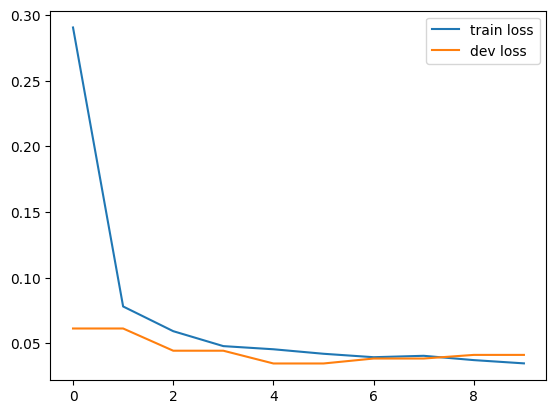

Test accuracy: 0.991


In [ ]:
# ploting
plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.show()

print('Test accuracy: {}'.format(test_acc))

If there isn't much difference between the training accuracy and validation accuracy, meaning they are closer to each other, it indicates that the model hasn't overfit. However, if there is a significant difference, or if the validation accuracy starts decreasing while the training accuracy increases, it's suspicious for overfitting. The accuracy lines should be smoother with fewer fluctuations. The presence of more fluctuations indicates instability in the model's performance, which could be a sign of overfitting.

If the Training Accuracy is continuously decreasing while the Validation Accuracy starts to increase or remains stable, this indicates overfitting. Conversely, if both training and validation accuracies consistently decrease or remain stable at similar levels, it indicates that the model has effectively learned. Ideally, we aim to steadily increase both Training and Validation accuracies or stabilize them at similar levels.

In [ ]:
# Small version

# ----- Backbone defs -----
input_chs=Xtr.shape[1] # the data is single-channel (grayscale)
hidden_chs=[16,16,]    # number of filters used in each convolutional layer
output_chs= 32         # number of channels in the output
kernels=3              # dimensions of the kernel or filter, which collects information from the images
conv_stride=1          # controls the stride for the cross-correlation, default is 1
paddings=1             # controls the amount of padding applied to each conv layer
max_pool=2             # performs pooling operations on the images
pool_stride=max_pool   # the stride of the pool window. Default value is pool_size
norm=1                 # BatchNorm in CNN layers
# ----- Head defs -----
input_dim=288
hidden_dim=[32,16,]    # dense (fully connected) layers
n_classes=10           # digits from 0 to 9
# ----- general defs -----
activation='relu'
dropout=0.1


model2= CNN_Model(input_chs, output_chs, hidden_chs, kernels, conv_stride, paddings,
                  max_pool, pool_stride, norm,
                  input_dim, n_classes, hidden_dim, activation, dropout).to(device)

total_params= sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

model2

Number of parameters: 17194


CNN_Model(
  (backbone): Backbone(
    (conv_in): ConvLayer(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): Activation(
        (activ): ReLU(inplace=True)
      )
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
    (conv_hiddens): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Activation(
          (activ): ReLU(inplace=True)
        )
        (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
    (conv_out): ConvLayer(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), st

In [ ]:
train_hist, dev_hist, test_acc= supervised_training(model2, learning_rate=1e-3, epochs=10,
                                                    eval_interval=2, cutoff=1e-6)

100%|██████████| 10/10 [24:17<00:00, 145.76s/it]


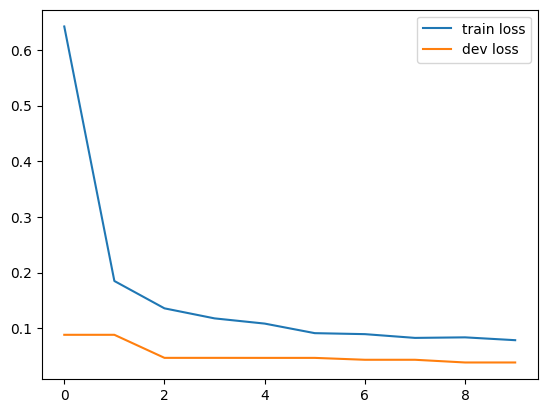

Test accuracy: 0.9913


In [ ]:
# ploting
plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.show()

print('Test accuracy: {}'.format(test_acc))

Small version trained using a large batch_size value -- improvement in the training time without significantly degrading test accuracy.

Errors start larger than previously and quickly reduce.

In [ ]:
# ----- reseting the small model -----
model2= CNN_Model(input_chs, output_chs, hidden_chs, kernels, conv_stride, paddings,
                  max_pool, pool_stride, norm,
                  input_dim, n_classes, hidden_dim, activation, dropout).to(device)

train_hist, dev_hist, test_acc= supervised_training(model2, learning_rate=1e-3, epochs=10,
                                                    batch_size=256, eval_interval=2, cutoff=1e-6)

100%|██████████| 10/10 [06:10<00:00, 37.07s/it]


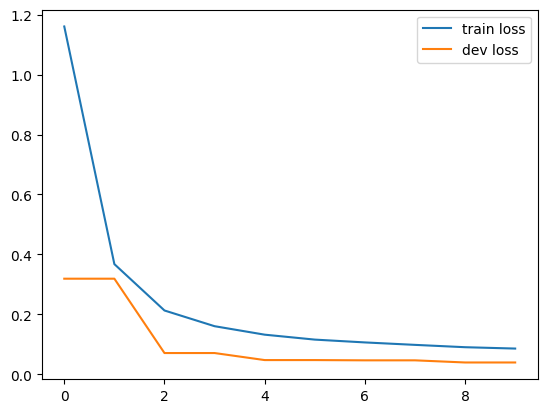

Test accuracy: 0.9909


In [ ]:
# ploting
plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.show()

print('Test accuracy: {}'.format(test_acc))

In [ ]:
# https://medium.com/thedeephub/convolutional-neural-networks-for-computer-vision-a913e77c60ff
# https://ai.gopubby.com/step-by-step-guide-to-building-an-artificial-neural-network-and-observing-how-overfitting-occurs-84961f96c7e8

# Self-Supervised Learning

Using stochastic data augmentation, contrastive loss, and projection heads. The supervised_training function is reused for fine-tuning.

See self_supervised_learning.ipynb

In [ ]:
"""
Creating an unlabeled dataset.

We will discard all but 500 of the training labels. That means we will have a set of 500 labeled images
to train from, and 59,500 unlabeled images to train from. This modification reflects the types of
applications in which self supervision is most useful: Datasets with a lot of data, but which are expensive
to label.
"""

# converting data to pytorch type
Xtr= torch.tensor(Xtr_raw, requires_grad=True).to(device)
Ytr= torch.tensor(Ytr_raw).to(device)

# transforming labels from numbers to one-hot vectors of length 10
Ytr= F.one_hot(Ytr.type(torch.int64), num_classes=10).type(torch.float32)


# defining the size of our labeled data
partition_index= 500

# creating a dev dataset with 20% of the labeled data size (100 validation samples)
tr_size= int(0.8*partition_index)


Xdev= Xtr[tr_size:partition_index]
Ydev= Ytr[tr_size:partition_index]

Xtr_unlabeled= Xtr[partition_index:]

Xtr= Xtr[:tr_size] # 400 samples for training
Ytr= Ytr[:tr_size] # discarding all but partition_index of the training labels


print(f'Shape of labeled training: Xtr - {Xtr.shape}, Ytr - {Ytr.shape}')
print(f'Shape of dev labeled data: Xdev - {Xdev.shape}, Ydev - {Ydev.shape}')
print(f'Shape of unlabeled training data: {Xtr_unlabeled.shape}')
print(f'Shape of test data: Xte - {Xte.shape}, Yte - {Yte.shape}')

Shape of labeled training: Xtr - torch.Size([400, 1, 28, 28]), Ytr - torch.Size([400, 10])
Shape of dev labeled data: Xdev - torch.Size([100, 1, 28, 28]), Ydev - torch.Size([100, 10])
Shape of unlabeled training data: torch.Size([59500, 1, 28, 28])
Shape of test data: Xte - torch.Size([10000, 1, 28, 28]), Yte - torch.Size([10000, 10])


# Data augmentation

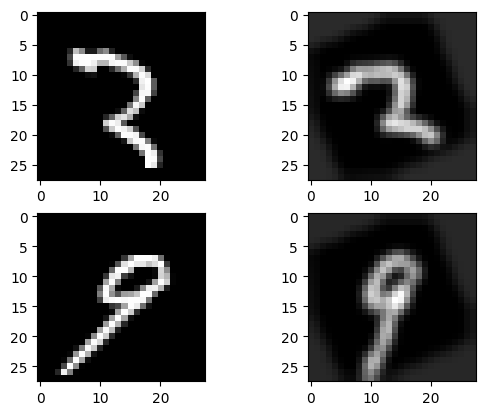

In [ ]:
import torchvision.transforms as T

class Augment:
    """
    A stochastic data augmentation module transforms any given data example randomly resulting in a
    correlated view of the same example, denoted x'i, which we consider as a positive pair.
    """

    def __init__(self):
        blur= T.GaussianBlur((3, 3), (0.1, 2.0))

        self.data_transform= torch.nn.Sequential(
            T.RandomAffine(degrees=(-50, 50), translate=(0.1, 0.1), scale=(0.5, 1.5), shear=0.2),
            T.RandomPerspective(0.4, 0.5),
            T.RandomPerspective(0.2, 0.5),
            T.RandomPerspective(0.2, 0.5),
            T.RandomApply([blur], p=0.25),
            T.RandomApply([blur], p=0.25)
        )

    def __call__(self, x):

        return self.data_transform(x)


# generating test augmentation
a= Augment()
aug= a(Xtr_unlabeled[0:2])

f, axarr= plt.subplots(2, 2)

# original image - positive pair
axarr[0, 0].imshow(Xtr_unlabeled[0][0].cpu().detach().numpy(), cmap='gray')
axarr[0, 1].imshow(aug[0][0].detach().cpu().numpy(), cmap='gray')

# original image - positive pair
axarr[1, 0].imshow(Xtr_unlabeled[1][0].cpu().detach().numpy(), cmap='gray')
axarr[1, 1].imshow(aug[1][0].detach().cpu().numpy(), cmap='gray')
plt.show()

# Contrastive loss function

**Contrastive loss** is the loss function used to entice positive pairs to be positioned closely in an embedding space, and negative pairs to be positioned further apart.

For more information see https://theaisummer.com/simclr/

In [ ]:
# Vanilla Contrastive loss, also called InfoNCELoss as in SimCLR paper

class ContrastiveLoss(nn.Module):

    def __init__(self, batch_size, temperature=0.5):
        """
        Defining certain constants used between calculations. The mask is important
        in understanding which are positive and negative examples.
        """
        super().__init__()
        self.batch_size= batch_size
        self.temperature= temperature
        self.mask= (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float().to(device)


    def calc_similarity_batch(self, a, b):
        """
        Defines the cosin similarity between one example, and all other examples.
        """
        representations= torch.cat([a, b], dim=0)

        return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)


    def forward(self, proj_1, proj_2):
        """
        The actual loss function, where proj_1 and proj_2 are embeddings from the projection head.
        This function calculates the cosin similarity between all vectors, and rewards closeness
        between examples which come from the same example, and farness for examples which do not.
        """
        batch_size= proj_1.shape[0]
        z_i= F.normalize(proj_1, p=2, dim=1)
        z_j= F.normalize(proj_2, p=2, dim=1)

        similarity_matrix= self.calc_similarity_batch(z_i, z_j)

        sim_ij= torch.diag(similarity_matrix, batch_size)
        sim_ji= torch.diag(similarity_matrix, -batch_size)

        positives= torch.cat([sim_ij, sim_ji], dim=0)

        nominator= torch.exp(positives / self.temperature)

        denominator= self.mask * torch.exp(similarity_matrix / self.temperature)

        all_losses= -torch.log(nominator / torch.sum(denominator, dim=1))
        loss= torch.sum(all_losses) / (2 * self.batch_size)

        return loss


# Self-Supervised Training procedure

Training the model to understand image similarity and difference via self-supervision and contrastive loss. Because this is an intermediary step, it's difficult to create clear and intuitive performance indicators.

Here, we are using the contrastive loss objective between original samples and augmented samples assumed to be positive pairs.

In [ ]:
# ExponentialLR can be used for both batch-based and step-based updates
from torch.optim.lr_scheduler import ExponentialLR

def self_supervised_training(model, learning_rate=1e-3, epochs=500, batches:bool=True, batch_size=64,
                             shuffle:bool=True, early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr_unlabeled.shape[0]/ batch_size)
    else:
        batch_size= Xtr_unlabeled.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate)

    # loss function
    loss_fn= ContrastiveLoss(batch_size).forward

    # for exponentially decreasing learning rate
    scheduler= ExponentialLR(optimizer, gamma=0.95)

    # data augmentation function
    augment_fn= Augment()

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    improvement_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr_unlabeled.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []
        batch_loss_change= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr_unlabeled.shape[0])[:Xtr_unlabeled.shape[0]]

        for i in range(epoch_size):
            # --- minibatch construction ---
            Xmb= Xtr_unlabeled[ix[(i * batch_size) : ((i+1) * batch_size)]]
            # creating a pair of augmented batches
            Xmb_aug= augment_fn(Xmb)

            # --- forward pass and get loss ---
            model.train(True)
            y_pred= model(Xmb)
            y_xaug= model(Xmb_aug)
            loss_tr= loss_fn(y_pred, y_xaug)
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


            # --- evaluation ---
            # checking if backpropagation resulted in a reduction of the loss
            model.train(False)
            with torch.no_grad():
                # passing through the model, now that parameters have been updated
                y_pred= model(Xmb)
                y_xaug= model(Xmb_aug)
                # calculating new loss value
                loss_new= loss_fn(y_pred, y_xaug)
                batch_loss_change.append((loss_new.item() - loss_tr.item()))

            batch_schedule.append(scheduler.get_last_lr())

        scheduler.step() # step learning rate scheduler


        # --- track stats ---
        train_hist.append(np.mean(batch_loss))
        schedule_hist.append(np.mean(batch_schedule))
        improvement_hist.append(np.mean(batch_loss_change))


        # --- early stopping -- calculating loss change ---
        per_loss_change= (previous_loss - train_hist[-1]) / previous_loss
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and per_loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    # --- final evaluation on the test set ---
    # it does not match with with the SSL training objective, only for curiosity
    model.train(False)
    with torch.no_grad():
        y_pred= model(Xte)
        test_acc= (y_pred.argmax(dim=1)== Yte.argmax(dim=1)).sum().item()/ Yte.shape[0]


    return train_hist, schedule_hist, test_acc


Running and comparing a Supervised learninig procedure with limited labeled data and a Self-Supervised learning procedure with quite more unlabeled data.

**NOTE:** a best practice is to keep batch_size as a power of two because it is computationally more efficient.

In [ ]:
"""
Reseting the small model (17K params) to evaluate its performance after a Supervised Training
using only 400 labeled training samples (100 for val).
"""

model2= CNN_Model(input_chs, output_chs, hidden_chs, kernels, conv_stride, paddings,
                  max_pool, pool_stride, norm,
                  input_dim, n_classes, hidden_dim, activation, dropout).to(device)

# once Xtr is now relatively small (400 samples) we use batch_size=100, i.e.,
# we will split Xtr in four batches at each epoch
train_hist, dev_hist, supe_acc= supervised_training(model2, learning_rate=1e-3, epochs=1000,
                                                    batch_size=100, eval_interval=20, cutoff=1e-6)

100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


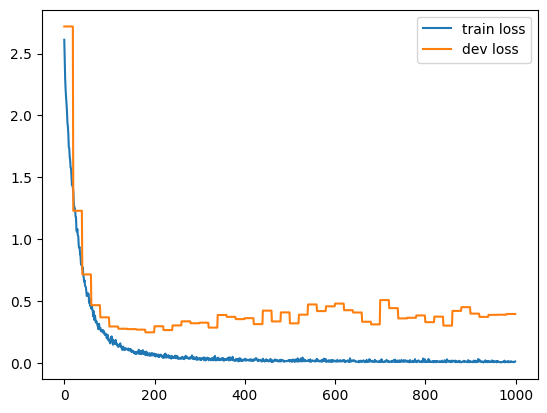

Test accuracy: 0.9202


In [ ]:
# training data is small and dev dataset is very small - we have more jitter here

plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.show()

print('Test accuracy: {}'.format(supe_acc))

Model accuracy is much lower when compared to this model's performance trained on the full labeled training data (> 0.99).

In [ ]:
"""
Reseting the small model (17K params) to perform a Self-Supervised Training procedure using
59,500 unlabeled training samples.
"""

model2= CNN_Model(input_chs, output_chs, hidden_chs, kernels, conv_stride, paddings,
                  max_pool, pool_stride, norm,
                  input_dim, n_classes, hidden_dim, activation, dropout).to(device)

train_hist, sched_hist, ssl_acc= self_supervised_training(model2, learning_rate=1e-2, epochs=50,
                                                          batch_size=256, cutoff=1e-7)

# it does not match with with the SSL training objective, only for curiosity
print('Test accuracy: {}'.format(ssl_acc))

100%|██████████| 50/50 [41:38<00:00, 49.97s/it]

Test accuracy: 0.069


Self-Supervised Training Progress


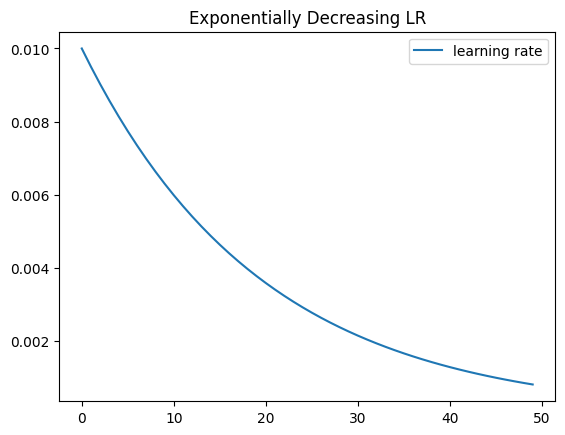

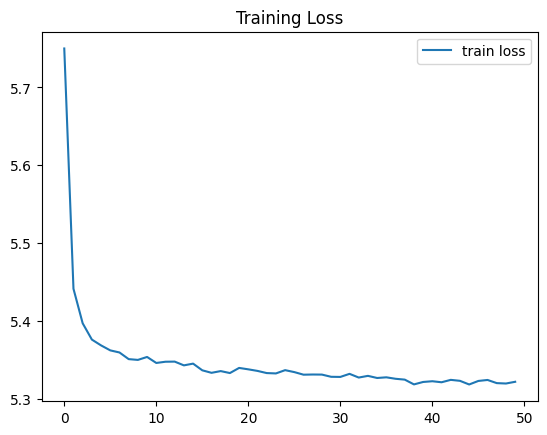

In [ ]:
print('Self-Supervised Training Progress')

plt.plot(sched_hist, label='learning rate')
plt.legend()
plt.title('Exponentially Decreasing LR')
plt.show()

print('\n')
plt.plot(train_hist, label='train loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Fine-Tuning the Self-Supervised Model with Supervised Learning

Training results with the original head


100%|██████████| 1000/1000 [09:26<00:00,  1.76it/s]


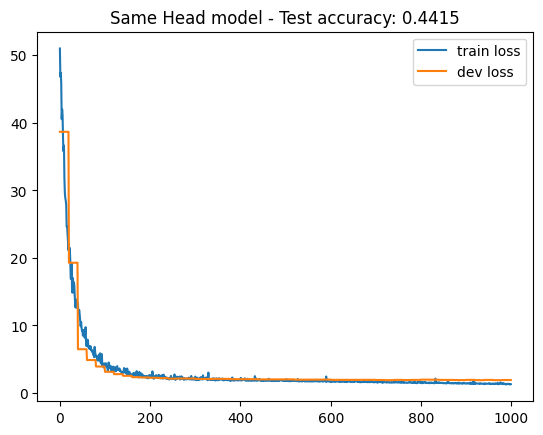



Training results with a randomly initialized head


100%|██████████| 1000/1000 [09:28<00:00,  1.76it/s]


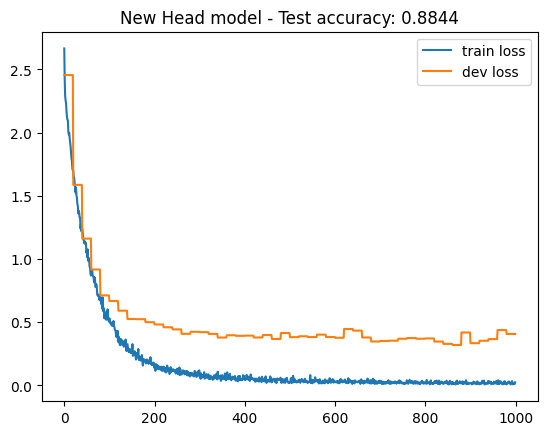

In [ ]:
import copy

# creating duplicate models for fine-tuning
model_same_head= copy.deepcopy(model2)
model_new_head = copy.deepcopy(model2)

# replacing the projection head with a randomly initialized head for one of the previous models
model_new_head.head= Head(input_dim, n_classes, hidden_dim, norm, activation, dropout).to(device)

# training models for Fine-Tuning - batch_size is a quarter of Xtr size (400/4= 100)
print('Training results with the original head')
train_hist, dev_hist, same_head_acc= supervised_training(model_same_head, learning_rate=1e-3,
                                                         epochs=1000, batch_size=100,
                                                         eval_interval=20, cutoff=1e-6)

plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.title(f'Same Head model - Test accuracy: {same_head_acc}')
plt.show()


print('\n\nTraining results with a randomly initialized head')
train_hist, dev_hist, new_head_acc= supervised_training(model_new_head, learning_rate=1e-3,
                                                        epochs=1000, batch_size=100,
                                                        eval_interval=20, cutoff=1e-6)

plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.title(f'New Head model - Test accuracy: {new_head_acc}')
plt.show()

A more sophisticated alternative for SSL would be creating positive and negative pairs and masking, such as in bert.ipynb.

In [ ]:
# https://towardsdatascience.com/self-supervised-learning-using-projection-heads-b77af3911d33

# AlexNet

Just building the model and testing with a dummy sample.

TODO:
- Training
- Experimenting with applying BatchNorm throughout the network.
- Performance comparison using different activations.

In [ ]:
# ----- Backbone defs -----
input_chs= 3                 # ImageNet data is 3-channel images (RGB)
hidden_chs=[96,256,384,384,] # number of filters used in each convolutional layer
output_chs= 256              # number of channels in the output
kernels=[11,5,3,3,3,]        # dimensions of the kernel or filter, which collects information from the images
conv_stride=[4,1,1,1,1,]     # controls the stride for the cross-correlation
paddings=[0,2,1,1,1,]        # controls the amount of padding applied to each conv layer
max_pool=[3,3,0,0,3,]        # performs pooling operations on the images
pool_stride=[2,2,0,0,2,]     # the stride of the pool window
norm=[1,1,0,0,0,]            # modern AlexNets have BatchNorms in conv layers 1 and 2
# ----- Head defs -----
input_dim= 9216
hidden_dim=[4096,4096,]      # dense (fully connected) layers
n_classes=1000               # 1000 - full ImageNet classes
# ----- general defs -----
activation='relu'
dropout=[0,0,0,0,0.5,0.5,0]  # the original AlexNet has 0.5 dropout only in layers 1 and 2 of the Head


AlexNet= CNN_Model(input_chs, output_chs, hidden_chs, kernels, conv_stride, paddings,
                   max_pool, pool_stride, norm,
                   input_dim, n_classes, hidden_dim, activation, dropout).to(device)

total_params= sum(p.numel() for p in AlexNet.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

AlexNet

Number of parameters: 62379048


CNN_Model(
  (backbone): Backbone(
    (conv_in): ConvLayer(
      (conv): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
      (norm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): Activation(
        (activ): ReLU(inplace=True)
      )
      (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_hiddens): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Activation(
          (activ): ReLU(inplace=True)
        )
        (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvLayer(
        (conv): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activ): Activation(
          (activ): ReLU(inplace=True)
        )
      )
     

In [ ]:
# test sample
Xtr_imageNet= torch.randint(low=0, high=255, size=(1,3,227,227)).type(torch.float32).to(device)
Xtr_imageNet.shape

torch.Size([1, 3, 227, 227])

In [ ]:
# testing the model - it works!
AlexNet(Xtr_imageNet).shape

torch.Size([1, 1000])

In [ ]:
# https://towardsdatascience.com/the-math-behind-deep-cnn-alexnet-738d858e5a2f

# Trainer Class

The Trainer class incorporates the entire training workflow, which includes iterating over epochs, managing the training loop, handling backpropagation, and implementing early stopping protocols to optimize training efficiency and efficacy.

In [ ]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after
    Args:
        patience (int): Number of epochs to wait before stopping the training.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        verbose (bool): If True, prints a message for each epoch where the loss does not improve.
    """

    def __init__(self, patience=7, cutoff=1e-9, verbose=False):
        self.patience= patience
        self.cutoff= cutoff
        self.verbose= verbose
        self.counter= 0
        self.last_loss= None
        self.early_stop= False


    def __call__(self, current_loss, epoch):
        """
        Args:
            val_loss (float): The validation loss to check if the model performance improved.
        Returns:
            bool: True if the loss did not improve, False if it improved.
        """
        if self.last_loss is None:
            self.last_loss= current_loss
        else:
            loss_change= np.abs(self.last_loss - current_loss)

            # deciding to stop if loss is not decreasing fast enough
            if loss_change< self.cutoff:
                self.counter += 1

                if self.counter> self.patience:
                    self.early_stop= True
                    if self.verbose:
                        print('\nEarly stopping at epoch {}'.format(epoch))
            else:
                self.counter= 0
            # setting current loss as previous loss
            self.last_loss= current_loss


In [ ]:
# ReduceLROnPlateau for adjusting the learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau

class Trainer:
    """
    Trainer class to train the model.
    Args:
        model (nn.Module): Neural network model.
        criterion (torch.nn.modules.loss): Loss function.
        optimizer (torch.optim): Optimizer.
        early_stop (bool): Wheter or not having early stopping.
        patience (int): Number of epochs to wait before stopping the training.
        cutoff (float): cutoff threshold of loss improvement for early stopping.
        verbose (bool): If True, prints status messages for each epoch.
    """

    def __init__(self, model, criterion, optimizer, early_stop=True, patience=7, cutoff=1e-9,
                 verbose=False):
        self.model= model
        self.criterion= criterion
        self.optimizer= optimizer
        self.early_stopping= None
        if early_stop:
            self.early_stopping= EarlyStopping(patience=patience, cutoff=cutoff, verbose=verbose)
        self.verbose= verbose
        # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
        self.scheduler= ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.1, min_lr=1e-6
        )
        self.train_losses= []
        self.eval_losses= []
        self.lr_hist= []


    def accuracy(self, test_data):
        """
        Calculate the accuracy of the model on the test dataset.
        Args:
            test_data (torch.tensor tuple): Datasets (Xte, Yte) for testing.
        Returns:
            float: Accuracy of the model on the test dataset.
        """
        Xte, Yte= test_data
        correct= 0

        self.model.train(False)
        with torch.no_grad():
            for i in range(Xte.shape[0]):
                data = Xte[i:i+1]
                label= Yte[i:i+1]

                y_pred= self.model(data)
                if (y_pred.argmax(dim=1)== label.argmax(dim=1)):
                    correct += 1

        return correct / Xte.shape[0]


    def evaluate(self, eval_data):
        """
        Evaluate the model on the test dataset.
        Args:
            eval_data (torch.tensor tuple): Datasets (Xdev, Ydev) for validation.
        Returns:
            float: Average loss on the dev/evaluation dataset.
        """
        Xdev, Ydev= eval_data
        total_loss= 0

        self.model.train(False)
        with torch.no_grad():
            for i in range(Xdev.shape[0]):
                data = Xdev[i:i+1]
                label= Ydev[i:i+1]

                y_pred= self.model(data)
                loss= self.criterion(y_pred, label)
                total_loss += loss.item()

        return total_loss / Xdev.shape[0]


    def supervised_training(self, train_data, eval_data, epochs=500, eval_interval=5,
                            batches:bool=True, batch_size=64, shuffle:bool=True):
        """
        Train the model.
        Args:
            train_data (torch.tensor tuple): Datasets (Xtr, Ytr) for training.
            eval_data (torch.tensor tuple): Datasets (Xdev, Ydev) for validation.
            epochs (int): Number of epochs to train the model.
            eval_interval (int): Interval of epochs to evaluate the model.
            batches (bool): If true, split the training data into minibatches.
            batch_size (int): Size of data minibatches.
            shuffle (bool): If true, shufles training data at each epoch.
        """
        Xtr, Ytr= train_data

        if batches:
            epoch_size= math.floor(Xtr.shape[0]/ batch_size)
        else:
            batch_size= Xtr.shape[0]
            epoch_size= 1

        # training data indexes
        ix= torch.arange(0, Xtr.shape[0])

        # --- training loop ---
        for epoch in range(epochs):

            batch_loss= []

            if shuffle:
                ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

            # iterating over all batches
            for i in range(epoch_size):
                # --- minibatch construction ---
                Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]
                Ymb= Ytr[ix[(i * batch_size) : ((i+1) * batch_size)]]

                # --- forward pass and get loss ---
                self.model.train(True)
                y_pred= self.model(Xmb)
                loss_tr= self.criterion(y_pred, Ymb)
                batch_loss.append(loss_tr.item())

                # --- backward pass to calculate the gradients ---
                self.optimizer.zero_grad()
                loss_tr.backward()

                # --- update the parameters using the gradient ---
                self.optimizer.step()

            # --- evaluation and track stats ---
            self.train_losses.append(np.mean(batch_loss))
            self.lr_hist.append(self.scheduler.get_last_lr())
            # best practice when using ReduceLROnPlateau is step on validation loss, but ok
            self.scheduler.step(self.train_losses[-1])

            if epoch% eval_interval== 0:
                loss_eval= self.evaluate(eval_data)

                if self.verbose:  # log the training and validation loss
                    print(f'Epoch {epoch}, Training Loss: {self.train_losses[-1]:.4f}, Validation Loss: {loss_eval:.4f}')

                # --- early stopping -- calculating loss change ---
                if self.early_stopping is not None:
                    self.early_stopping(current_loss=loss_eval, epoch=epoch)

                    if self.early_stopping.early_stop:
                        self.eval_losses.append(loss_eval)
                        self.model.train(False)
                        break

            self.eval_losses.append(loss_eval)


    def plot_losses(self):
        # Plot
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.eval_losses, label='Validation Loss')
        plt.title('Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()


Running the Trainer class using the 17k parameters CNN model (supervised training only).

In [ ]:
# ----- Backbone defs -----
input_chs= Xtr.shape[1] # the data is single-channel (grayscale)
hidden_chs=[16,16,]     # number of filters used in each convolutional layer
output_chs= 32          # number of channels in the output
kernels=3               # dimensions of the kernel or filter, which collects information from the images
conv_stride=1           # controls the stride for the cross-correlation, default is 1
paddings=1              # controls the amount of padding applied to each conv layer
max_pool=2              # performs pooling operations on the images
pool_stride=max_pool    # the stride of the pool window. Default value is pool_size
norm=1                  # BatchNorm in CNN layers
# ----- Head defs -----
input_dim= 288
hidden_dim=[32,16,]     # dense (fully connected) layers
n_classes=10            # digits from 0 to 9
# ----- general defs -----
activation='relu'
dropout=0.1
init='he'

# ----- reseting the model -----
model= CNN_Model(input_chs, output_chs, hidden_chs, kernels, conv_stride, paddings,
                 max_pool, pool_stride, norm,
                 input_dim, n_classes, hidden_dim, activation, dropout, init).to(device)

# training setup
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
early_stop=True
patience=5
cutoff=1e-6
verbose=True

trainer= Trainer(model, criterion, optimizer, early_stop, patience, cutoff, verbose)
trainer.supervised_training(train_data=(Xtr, Ytr), eval_data=(Xdev, Ydev),
                            epochs=10, eval_interval=1, batch_size=256)


Epoch 1, Training Loss: 1.2561, Validation Loss: 0.4230
Epoch 2, Training Loss: 0.3680, Validation Loss: 0.1132
Epoch 3, Training Loss: 0.1991, Validation Loss: 0.0735
Epoch 4, Training Loss: 0.1503, Validation Loss: 0.0538
Epoch 5, Training Loss: 0.1254, Validation Loss: 0.0496
Epoch 6, Training Loss: 0.1085, Validation Loss: 0.0466
Epoch 7, Training Loss: 0.1002, Validation Loss: 0.0407
Epoch 8, Training Loss: 0.0947, Validation Loss: 0.0412
Epoch 9, Training Loss: 0.0882, Validation Loss: 0.0386
Epoch 10, Training Loss: 0.0803, Validation Loss: 0.0365


Test Accuracy: 99.14%


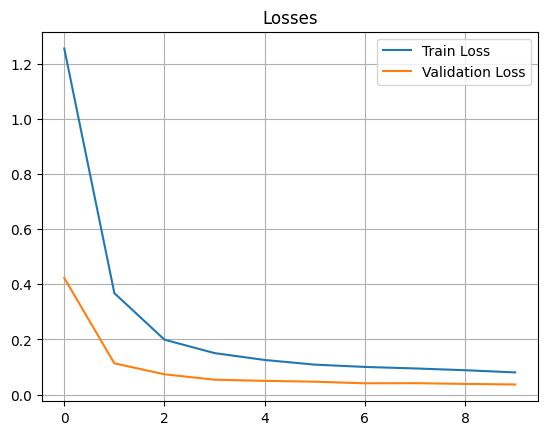

In [ ]:
accuracy= trainer.accuracy(test_data=(Xte, Yte))
print(f'Test Accuracy: {accuracy:.2%}')

trainer.plot_losses()

In [ ]:
# https://towardsdatascience.com/the-math-behind-deep-cnn-alexnet-738d858e5a2f
# https://towardsdatascience.com/the-math-behind-fine-tuning-deep-neural-networks-8138d548da69